In [58]:
import pandas as pd
import numpy as np
import torch
import sklearn.metrics as metrics
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler
from ogb.nodeproppred import PygNodePropPredDataset
import torch.nn as nn
import torch.optim as optim
import pickle

import matplotlib.pyplot as plt

In [59]:
from ogb.nodeproppred import PygNodePropPredDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = PygNodePropPredDataset(name = "ogbn-products")
dataset = TensorDataset(torch.tensor(dataset[0].x).to(torch.device(device)), torch.tensor(dataset[0].y).to(torch.device(device)))

/var/folders/pz/_8g6shcx1d78s5c66xg7wqlm0000gn/T/ipykernel_11483/1905207695.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(dataset[0].x).to(torch.device(device)), torch.tensor(dataset[0].y).to(torch.device(device)))


In [60]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
batch_size = 1024
generator1 = torch.Generator().manual_seed(42)

In [61]:
_, _, bow_test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=generator1)
bow_test_loader = DataLoader(bow_test_set, batch_size=batch_size, shuffle=True)

In [62]:
try: 
    with open("../dataset/dataset.pkl", "rb") as o:
        data = pickle.load(o)

    dataset = TensorDataset(torch.tensor(data.x).to(torch.device(device)), torch.tensor(data.y).to(torch.device(device)))
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    _, _, bert_test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=generator1)
    bert_test_loader = DataLoader(bert_test_set, batch_size=batch_size, shuffle=True)
except: 
    print("BERT data not found")

In [63]:
bow_model = torch.load("../models/bow-model-checkpoint-100.pt", map_location=torch.device('cpu'))
bert_model = torch.load("../models/embedding-model-checkpoint-150.pt", map_location=torch.device('cpu'))

In [64]:
def evaluate_model(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    for data in loader:
        x, y = data
        y_true.append(y)
        y_pred.append(torch.argmax(model(x), dim=1))
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    #calculate accuracy score
    accuracy = metrics.accuracy_score(y_true.cpu().numpy(), y_pred.cpu().numpy())
    f1 = metrics.f1_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), average='weighted')

    return accuracy, f1

In [65]:
bow_model_state = torch.load('../models/bow-model-checkpoint-100.pt', map_location=torch.device('cpu'))
bert_model_state = torch.load('../models/embedding-model-checkpoint-150.pt', map_location=torch.device('cpu'))

In [66]:
class BOWNet(nn.Module):
    
    def __init__(self):
        super(BOWNet, self).__init__()

        self.fc2 = nn.Linear(100, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 47)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc5(x)

        return x

In [67]:
bow_model = BOWNet()
bow_model.load_state_dict(bow_model_state['model_state_dict'])
bow_model.eval()

BOWNet(
  (fc2): Linear(in_features=100, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=47, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [68]:
bow_acc, bow_f1 = evaluate_model(bow_model, bow_test_loader)

In [69]:
class BERTNet(nn.Module):
    def __init__(self):
        super(BERTNet, self).__init__()
        self.fc1 = nn.Linear(384, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 47)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
     
        
        return x

In [70]:
bert_model = BERTNet()
bert_model.load_state_dict(bert_model_state['model_state_dict'])
bert_model.eval()

BERTNet(
  (fc1): Linear(in_features=384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=47, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [71]:
summary(bert_model, (384,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         197,120
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 47]           6,063
Total params: 367,407
Trainable params: 367,407
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.40
Estimated T

In [72]:
bert_acc, bert_f1 = evaluate_model(bert_model, bert_test_loader)

## Visualize MLP Results

Text(0.5, 1.0, 'F1 Score')

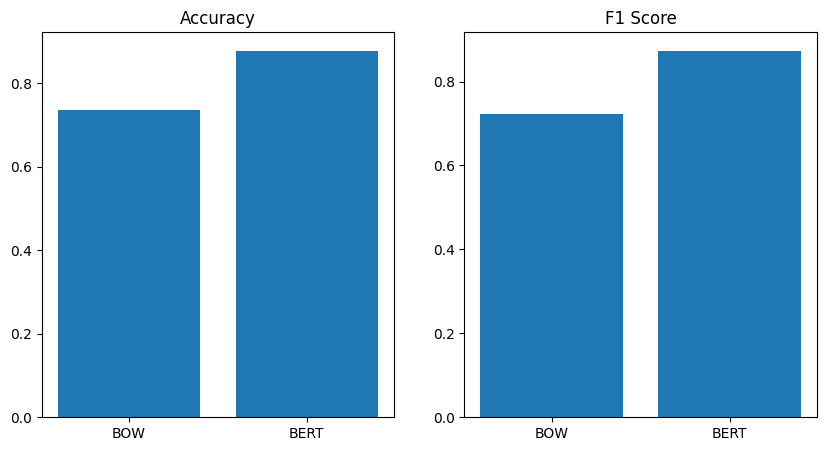

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axes.flatten()

ax1.bar(["BOW", "BERT"], [bow_acc, bert_acc])
ax1.set_title("Accuracy")

ax2.bar(["BOW", "BERT"], [bow_f1, bert_f1])
ax2.set_title("F1 Score")